In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [7]:
# Read CSV file
file_path = r"/workspaces/rumour-detection-pheme/Dataset creation/charliehebdo-all-rnr-threads.csv"
df = pd.read_csv(file_path)


In [8]:
df.groupby('rumour')['id'].nunique()

rumour
0    1555
1     447
Name: id, dtype: int64

In [9]:
df.time = pd.to_datetime(df.time, format='%a %b %d %H:%M:%S +0000 %Y')
df.reply_time = pd.to_datetime(df.reply_time, format='%a %b %d %H:%M:%S +0000 %Y')

### Time for replies x Number of replies

In [10]:
 df['time_diff']=(df.reply_time - df.time).dt.total_seconds()/60

In [11]:
df['reply_number'] = df.groupby('id')['time_diff'].rank(method='dense')

In [12]:
df_reply_time = (df.groupby(['reply_number','rumour'])['time_diff'].median()).to_frame(name='time_diff_minutes').reset_index()
df_reply_time.reply_number = df_reply_time.reply_number.astype('int')

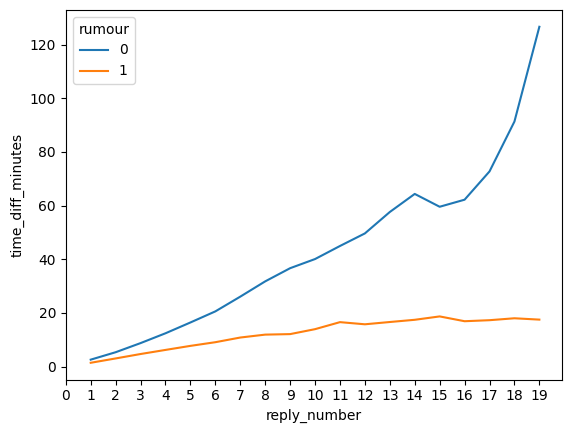

In [13]:
sns.lineplot(data=df_reply_time, x='reply_number', y='time_diff_minutes',hue='rumour')
# Set custom x-axis values
custom_xticks = np.arange(0,20,1) # specify the desired x-axis values
plt.xticks(custom_xticks)
plt.show()

#### Time for first reply x Number of replies

In [14]:
df_first_tm_diff = df.groupby(['id','rumour']).agg(replies=('time_diff','count')\
                      ,first_time_diff=('time_diff','first')).reset_index()\
                  .groupby(['rumour','replies'])['first_time_diff'].median()\
                  .to_frame().reset_index()

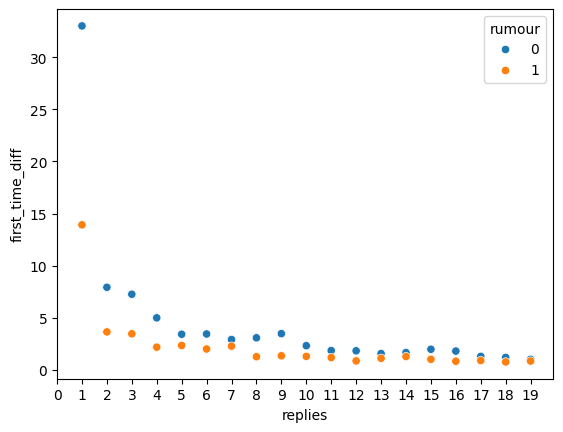

In [15]:
sns.scatterplot(data=df_first_tm_diff, x='replies', y='first_time_diff',hue='rumour')
custom_xticks = np.arange(0,20,1) # specify the desired x-axis values
plt.xticks(custom_xticks)
plt.show()

#### Number of replies x Retweet counts

In [16]:
df_posts = df[['id','text','followers','favorite_count','retweet_count','verified',\
  'rumour','user_id']].drop_duplicates().merge(df.groupby(['id']).agg(replies=(\
  'time_diff','count'),first_time_diff=('time_diff','first')).reset_index(),\
  on="id",how="left")

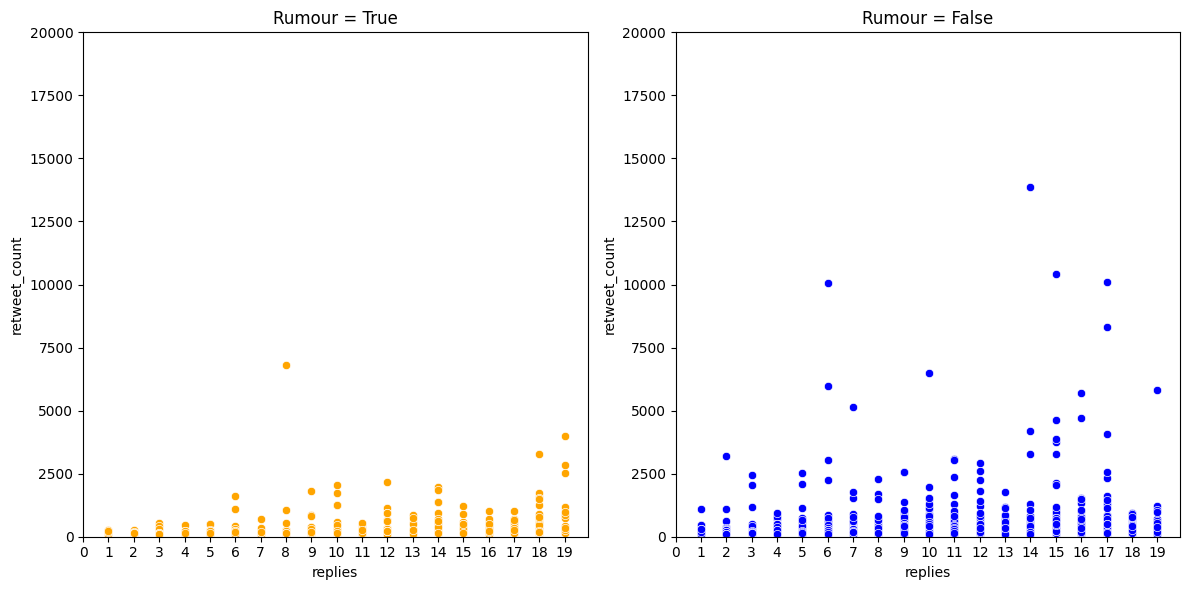

In [17]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='replies', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
#axs[0].set_xlim(0, 5000)
axs[0].set_ylim(0, 20000)
custom_xticks = np.arange(0, 20, 1)
axs[0].set_xticks(custom_xticks)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='replies', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
#axs[1].set_xlim(0, 5000)
axs[1].set_ylim(0, 20000)
custom_xticks = np.arange(0, 20, 1)
axs[1].set_xticks(custom_xticks)

plt.tight_layout()
plt.show()

#### Favorite counts x Retweet counts

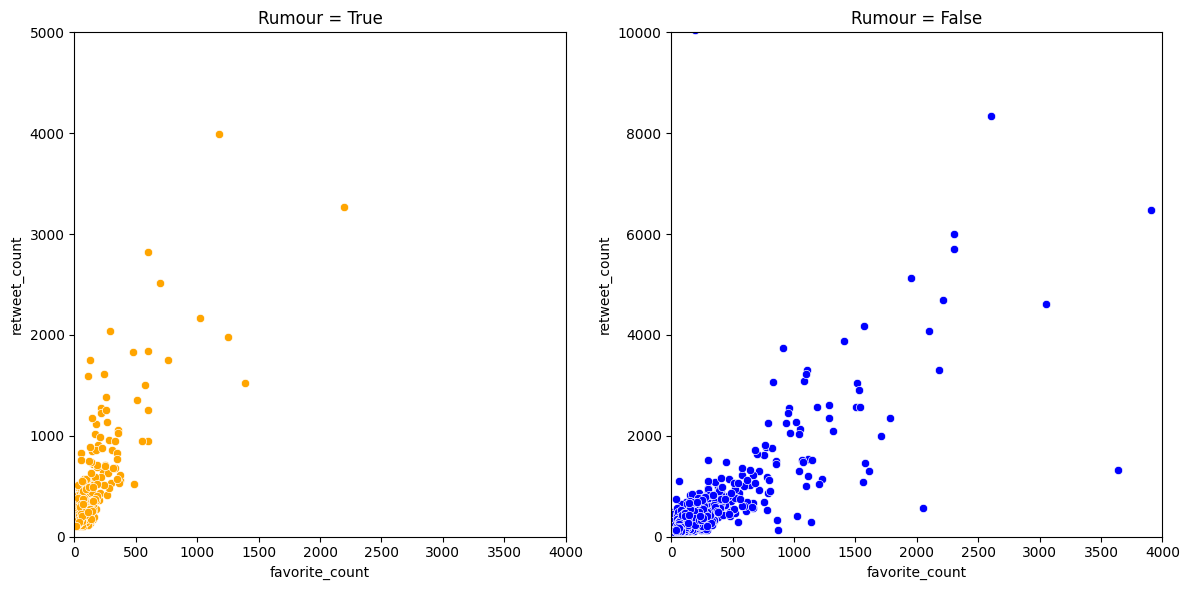

In [18]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='favorite_count', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
axs[0].set_xlim(0, 4000)
axs[0].set_ylim(0, 5000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='favorite_count', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
axs[1].set_xlim(0, 4000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Retweet count x Time for first reply

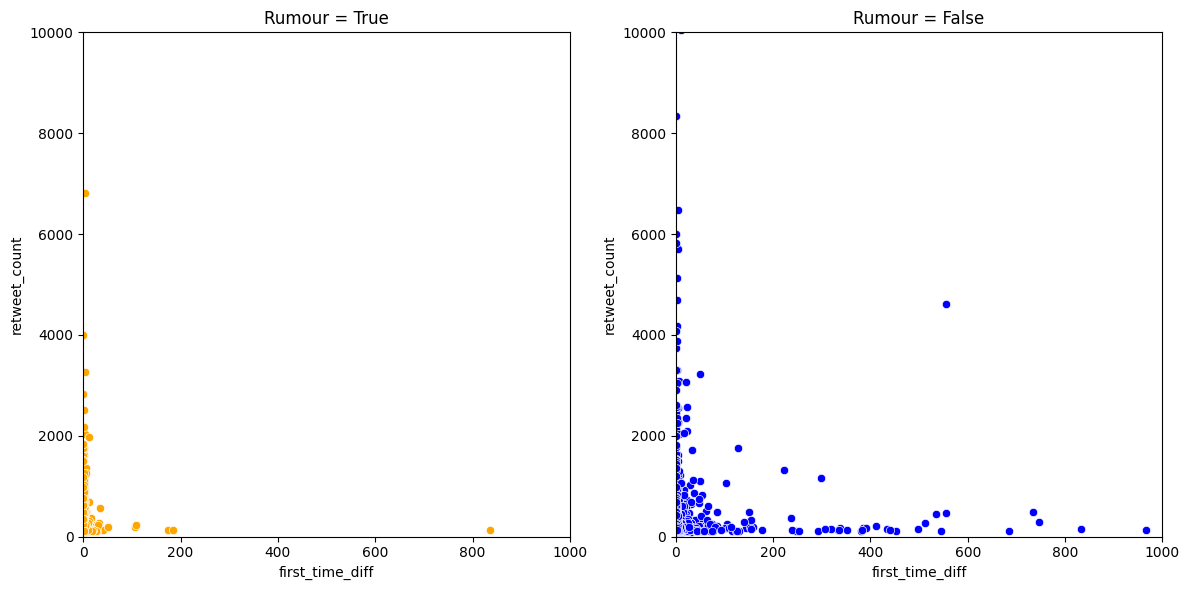

In [19]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='first_time_diff', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 10000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='first_time_diff', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Followers vs Retweet counts

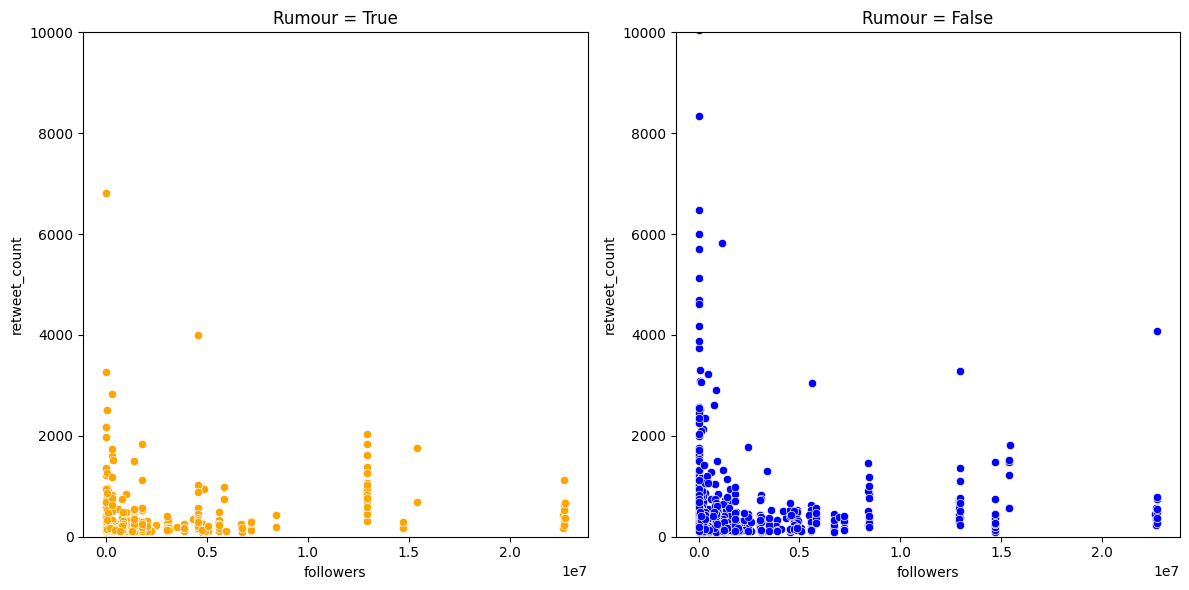

In [20]:
# Create subplots with 1 row and 2 columns
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Scatter plot for rumour == True
sns.scatterplot(data=df_posts[df_posts['rumour'] == 1], x='followers', y='retweet_count',color='orange', ax=axs[0])
axs[0].set_title('Rumour = True')
#axs[0].set_xlim(0, 1000)
axs[0].set_ylim(0, 10000)

# Scatter plot for rumour == False
sns.scatterplot(data=df_posts[df_posts['rumour'] == 0], x='followers', y='retweet_count',color='blue', ax=axs[1])
axs[1].set_title('Rumour = False')
#axs[1].set_xlim(0, 1000)
axs[1].set_ylim(0, 10000)


plt.tight_layout()
plt.show()

#### Word embeddings

In [21]:
# Download NLTK stopwords
nltk.download('stopwords')

english_stopwords = nltk.corpus.stopwords.words('english')

# function for cleaning data
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt


def clean_text(
    string: str,
    punctuations=r'''!()-[]{};:'"\,<>./?@#$%^&*_~''',
    stop_words=english_stopwords) -> str:
    """
    A method to clean text
    """
    # Cleaning the urls
    string = re.sub(r'https?://\S+|www\.\S+', '', string)

    # Cleaning the html elements
    string = re.sub(r'<.*?>', '', string)

    # Removing the punctuations
    for x in string.lower():
        if x in punctuations:
            string = string.replace(x, "")

    # Converting the text to lower
    string = string.lower()

    # Removing stop words
    string = ' '.join([word for word in string.split() if word not in stop_words])

    # Cleaning the whitespaces
    string = re.sub(r'\s+', ' ', string).strip()

    return string

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
df_posts['clean_text'] = np.vectorize(remove_pattern)(df_posts['text'], "@[\w]*")
df_posts['clean_text'] = df_posts['clean_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

In [23]:
# create the dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_posts['clean_text'])

In [24]:
print("Longest length is: ",df_posts.clean_text.str.len().max())

Longest length is:  127


In [25]:
def embedding_vocab(filepath, word_index,embedding_dim):
    vocab_size = len(word_index) + 1


    embedding_matrix_vocab = np.zeros((vocab_size,
                                       embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word]
                embedding_matrix_vocab[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix_vocab

In [26]:
#!wget https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
#!unzip -q glove.6B.zip

In [27]:
embedding_dim = 100
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [28]:
tokenizer.word_index['terrorist']

32

In [29]:
embedding_matrix_vocab[32]

array([ 2.61329988e-04,  3.27170014e-01, -5.27490020e-01, -6.99689984e-01,
        5.68310022e-01, -1.64810002e-01, -4.63490009e-01, -1.06669998e+00,
        7.11060017e-02,  1.34609997e+00,  4.05539989e-01,  7.92929977e-02,
        5.70400000e-01,  4.85280007e-01,  1.60490006e-01,  1.35200000e+00,
       -6.25209987e-01, -9.24429968e-02, -9.80400026e-01,  4.38950002e-01,
        1.12310000e-01, -2.42149994e-01,  2.77770013e-01, -7.61640012e-01,
       -9.54079986e-01,  3.74170005e-01,  4.12420005e-01,  9.61040035e-02,
        8.47470015e-02,  2.55450010e-01,  4.38340008e-01, -1.25060007e-01,
       -1.60779998e-01,  1.24240004e-01,  1.52309999e-01, -1.64389998e-01,
       -3.27900015e-02, -4.91930008e-01,  5.06540000e-01,  2.00389996e-01,
       -5.87509990e-01,  2.10769996e-01,  1.22230005e+00,  5.09630024e-01,
        1.11189997e+00, -2.26009995e-01,  9.64810014e-01,  6.00089990e-02,
       -6.84650004e-01, -3.28599989e-01,  2.12280005e-02,  9.96940017e-01,
        5.38230002e-01,  

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarities(embedding_matrix, word_index, word):
    idx = word_index.get(word)
    if idx is None:
        return None
    vector = embedding_matrix[idx].reshape(1, -1)
    similarities = cosine_similarity(vector, embedding_matrix)
    return similarities[0]

In [31]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'terrorist')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

terror
terrorists
terrorism
attacks
qaeda


In [32]:
similarities = cosine_similarities(embedding_matrix_vocab, tokenizer.word_index, 'cowards')
similar_indices = similarities.argsort()[::-1]
for idx in similar_indices[1:6]:  # excluding the word itself
    word = tokenizer.index_word[idx]
    print(word)

hypocrites
morons
savages
idiots
cowardly


In [33]:
# Tokenize text
sequences = tokenizer.texts_to_sequences(df_posts['clean_text'])

# Padding sequences if necessary
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Function to get embeddings for a sequence
def get_embeddings(sequence, embedding_matrix):
    embeddings = []
    for idx in sequence:
        embeddings.append(embedding_matrix[idx])
    return np.array(embeddings)

# Apply function to get embeddings for each sequence
df_posts['embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [34]:
array_avg = []
for i in df_posts.embeddings:
  array_avg.append(np.mean(i,axis=0))
df_posts['embeddings_avg'] = array_avg

In [35]:
idx =1522
vector = df_posts.iloc[idx].embeddings_avg.reshape(1,100)
embedding_matrix = np.vstack(df_posts.embeddings_avg.values)
similarities = cosine_similarity(vector, embedding_matrix)[0]

similar_indices = similarities.argsort()[::-1]
print(df_posts.iloc[idx].text,"\n")
for idx in similar_indices[1:6]:  # excluding the word itself
    tweet = df_posts.iloc[idx].text
    print(tweet)

Details of attacks on Muslim community in France, grenades, &amp; shootings in aftermath of the #CharlieHebdo attack http://t.co/4u5fsWL75w 

Two mosque attacks reported in wake of Charlie Hebdo attack  
http://t.co/mPr3rXnx7i #C4News
French leader: Attack that killed 11 at Paris newspaper an act of terror, other attacks thwarted in recent weeks: http://t.co/9rrqfEaQj5
Revenge attacks on Muslim spaces begin in France after #CharlieHebdo massacre http://t.co/50anhW9BEk http://t.co/uKL5El7V2B
A shocking number of attacks against French Muslims and mosques days after the #CharlieHebdo massacre: http://t.co/0DokPJ98EB
France: Since last night, gunfire and bombings have targeted two mosques, a prayer room, and a Muslim family's car. http://t.co/fXrG6y2uvX


#### Reply embeddings

In [36]:
df['clean_reply_text'] = np.vectorize(remove_pattern)(df['reply_text'], "@[\w]*")
df['clean_reply_text'] = df['clean_reply_text'].str.replace("[^a-zA-Z#]", " ").apply(clean_text)

In [37]:
# create the dictionary
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_reply_text'])

In [38]:
embedding_dim = 100
embedding_matrix_vocab = embedding_vocab(
    'glove.6B.100d.txt', tokenizer.word_index,
embedding_dim)

In [39]:
# Tokenize text
sequences = tokenizer.texts_to_sequences(df['clean_reply_text'])

# Padding sequences if necessary
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Apply function to get embeddings for each sequence
df['reply_embeddings'] = [get_embeddings(seq, embedding_matrix_vocab) for seq in sequences]

In [40]:
array_avg = []
for i in df.reply_embeddings:
  array_avg.append(np.mean(i,axis=0))
df['reply_embeddings_avg'] = array_avg

/home/codespace/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/codespace/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [41]:

df['reply_embeddings_avg'] = df['reply_embeddings_avg'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(100))

In [37]:
import pandas as pd
import networkx as nx
import plotly.graph_objects as go
import matplotlib.pyplot as plt
file_path_replies = r"/workspaces/rumour-detection-pheme/replies_charlie_hebdo.pkl"
df = pd.read_pickle(file_path_replies)

In [80]:
df[df.id==552783238415265792].reply_text.values

array(['@H_E_Samuel @George_Berridge @michael_taggart The religion of peace strikes again.',
       '@H_E_Samuel Hi Henry would you be willing to give ITV News a phone interview for our Lunchtime bulletin in 2 hours?',
       "@H_E_Samuel @H_E_Samuel please call them terrorists not gunmen, don't dilute the news because if we  do that they sure will run over us",
       '@H_E_Samuel French govt needs to take strict action.',
       "@H_E_Samuel @terrychristian  if only people didn't hand out guns:https://t.co/iPBkLwhQk8 Jeffrey Epstein also in CFR+Trilateral Commission"],
      dtype=object)

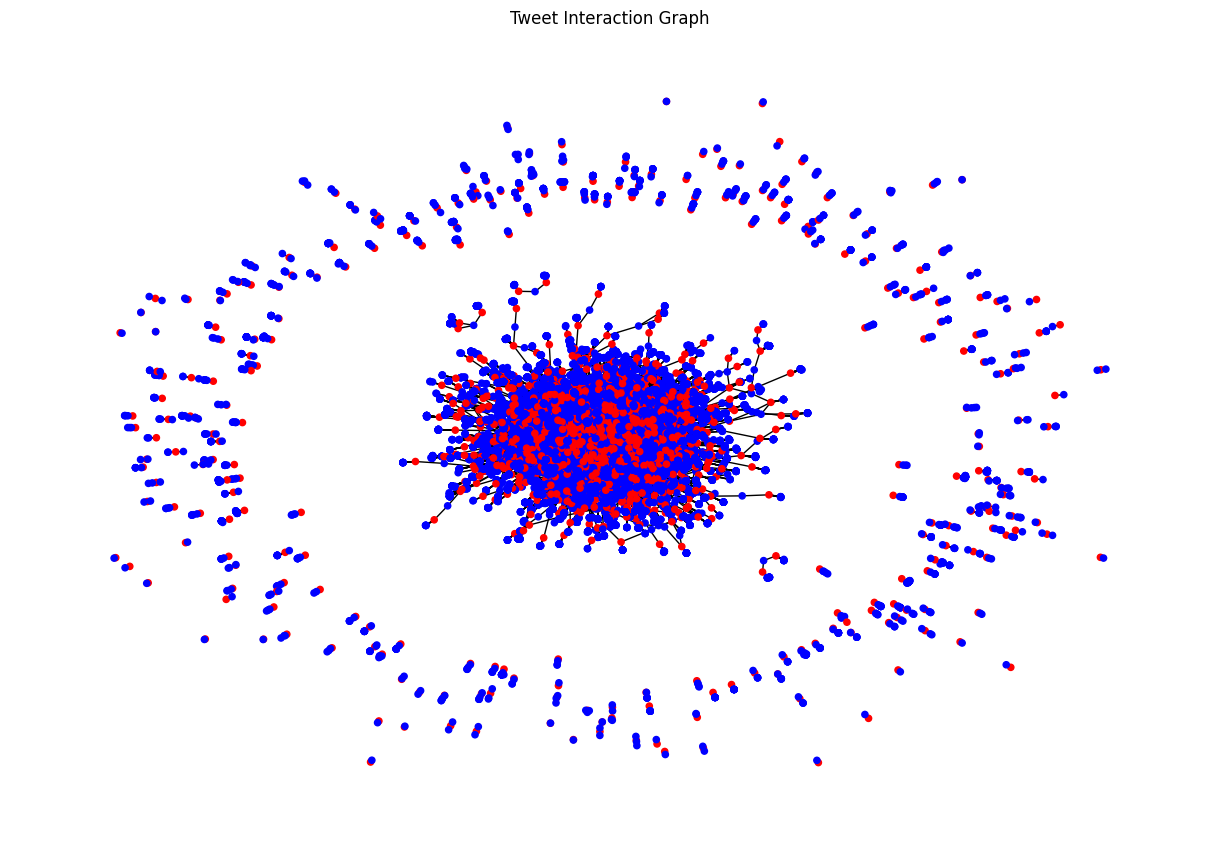

In [38]:
# Create the graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}

# Assign colors to nodes
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node colors
colors = [node_colors[node] for node in G.nodes()]



1# Layout for the graph
pos = nx.spring_layout(G)

# Plot the graph
plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=False, node_size=20, node_color=colors, edge_color='black')
plt.title('Tweet Interaction Graph')
plt.show()

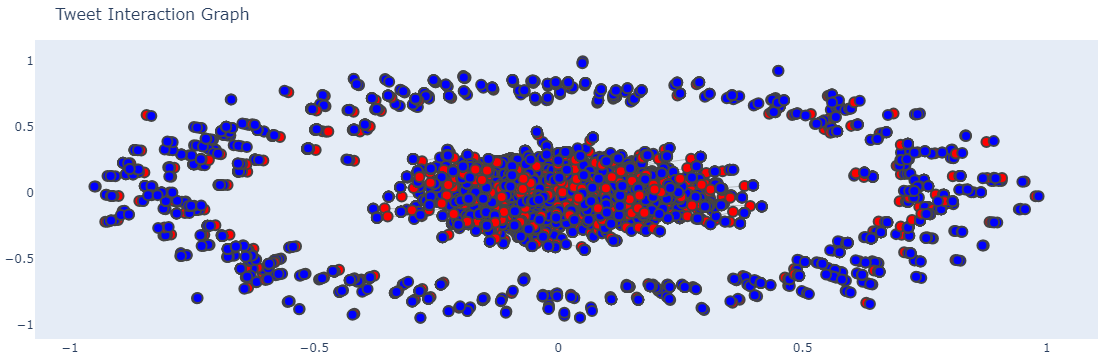

In [53]:
# Create the graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node positions using a layout
pos = nx.spring_layout(G)

# Extract edges and their positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Extract node positions and colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

# Show the figure
fig.show()

#### Usuários que interagiram com os mesmos posts

In [39]:
# Group by 'id' and aggregate 'user_id' into a list of unique users
grouped_df = df.groupby('id')['reply_user_id'].apply(lambda x: list(set(x)))

# Function to create co-occurrence dictionary for n-sized combinations
def create_co_occurrence(n):
    co_occurrence = {}

    # Iterate over each post and its unique users
    for users in grouped_df:
        # Create all unique n-sized combinations of users
        for combo in itertools.combinations(sorted(users), n):
            # Increment the count for each combination
            if combo in co_occurrence:
                co_occurrence[combo] += 1
            else:
                co_occurrence[combo] = 1

    # Convert the dictionary to a DataFrame
    co_occurrence_df = pd.DataFrame(
        [(list(combo), count) for combo, count in co_occurrence.items()],
        columns=['user_combination', 'count']
    )

    return co_occurrence_df

# Function to find the combinations with the highest count
def find_highest_combinations(co_occurrence_df):
    # Find the maximum count
    max_count = co_occurrence_df['count'].max()

    # Get the combinations with the highest count
    most_frequent_combinations = co_occurrence_df[co_occurrence_df['count'] == max_count]

    return most_frequent_combinations


In [56]:
# Example usage for 2, 3, and 4 users
n = 4
co_occurrence_df = create_co_occurrence(n)
most_frequent_combinations = find_highest_combinations(co_occurrence_df)
most_frequent_combinations

user_combination  count
532057   [48304732, 1849407440, 2886586060, 2962064392]      2
1067656     [34126592, 102692275, 174365756, 191231615]      2
1067663    [34126592, 102692275, 174365756, 1030435626]      2
1067680    [34126592, 102692275, 191231615, 1030435626]      2
1067725    [34126592, 174365756, 191231615, 1030435626]      2
1069215   [102692275, 174365756, 191231615, 1030435626]      2

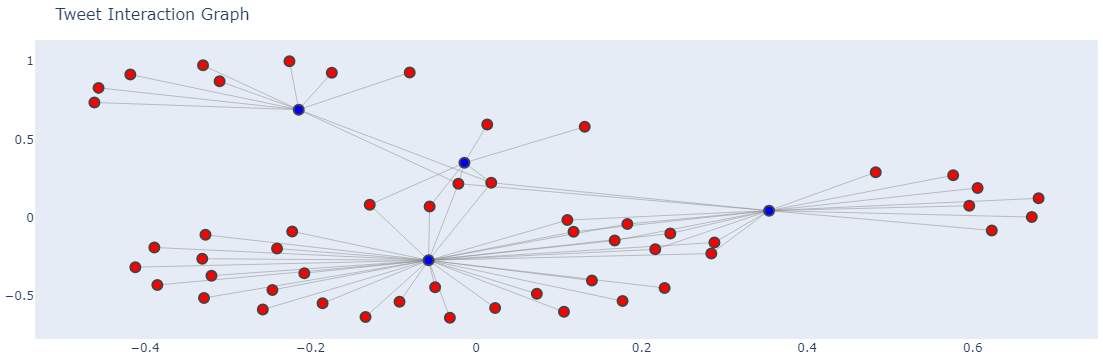

In [57]:
# Create the graph
reply_user_ids = most_frequent_combinations['user_combination'].values[0]

G = nx.Graph()
for _, row in df[df.reply_user_id.isin(reply_user_ids)].iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node positions using a layout
pos = nx.spring_layout(G)

# Extract edges and their positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Extract node positions and colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

# Show the figure
fig.show()

In [59]:


# Group by 'user_id' and aggregate 'id' into a list of unique posts
grouped_df = df.groupby('reply_user_id')['id'].apply(lambda x: list(set(x)))

# Function to create co-occurrence dictionary for n-sized combinations
def create_post_co_occurrence(n):
    co_occurrence = {}

    # Iterate over each user's posts
    for posts in grouped_df:
        # Create all unique n-sized combinations of posts
        for combo in itertools.combinations(sorted(posts), n):
            # Increment the count for each combination
            if combo in co_occurrence:
                co_occurrence[combo] += 1
            else:
                co_occurrence[combo] = 1

    # Convert the dictionary to a DataFrame
    co_occurrence_df = pd.DataFrame(
        [(list(combo), count) for combo, count in co_occurrence.items()],
        columns=['post_combination', 'count']
    )

    return co_occurrence_df

# Function to find the combinations with the highest count
def find_highest_post_combinations(co_occurrence_df):
    # Find the maximum count
    max_count = co_occurrence_df['count'].max()

    # Get the combinations with the highest count
    most_frequent_combinations = co_occurrence_df[co_occurrence_df['count'] == max_count]

    return most_frequent_combinations

In [66]:

# Example usage for 2, 3, and 4 posts
n = 5
co_occurrence_df = create_post_co_occurrence(n)
most_frequent_post_combinations = find_highest_post_combinations(co_occurrence_df)
most_frequent_post_combinations

post_combination  count
1140468  [553097004138913792, 553099479381848064, 55310...      2
1213051  [553097004138913792, 553132819237462016, 55314...      2
1213052  [553097004138913792, 553132819237462016, 55314...      2
1213053  [553097004138913792, 553132819237462016, 55314...      2
1213054  [553097004138913792, 553132819237462016, 55314...      2
...                                                    ...    ...
4370410  [553148970651107329, 553151749008424960, 55315...      2
4370421  [553148970651107329, 553151749008424960, 55315...      2
4370442  [553148970651107329, 553151749008424960, 55315...      2
4370498  [553148970651107329, 553152675014246400, 55315...      2
4370624  [553151749008424960, 553152675014246400, 55315...      2

[1104 rows x 2 columns]

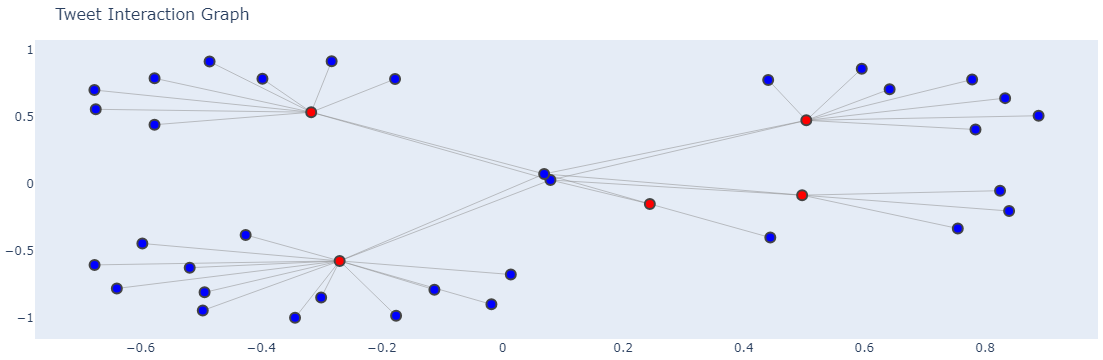

In [67]:
# Create the graph
post_ids = most_frequent_post_combinations['post_combination'].values[0]

G = nx.Graph()
for _, row in df[df.id.isin(post_ids)].iterrows():
    G.add_edge(row['id'], row['reply_user_id'])

# Determine unique node types for coloring
node_types = {'id': 'red', 'reply_user_id': 'blue'}

# Initialize node colors
node_colors = {}
for node in G.nodes():
    if node in df['id'].values:
        node_colors[node] = node_types['id']
    elif node in df['reply_user_id'].values:
        node_colors[node] = node_types['reply_user_id']

# Extract node positions using a layout
pos = nx.spring_layout(G)

# Extract edges and their positions
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

# Extract node positions and colors
node_x = []
node_y = []
node_color = []
for node in G.nodes():
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_color.append(node_colors[node])

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=0.5, color='#888'),
    hoverinfo='none',
    mode='lines')

# Create node trace
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='none',
    marker=dict(
        showscale=False,
        colorscale='YlGnBu',
        color=node_color,
        size=10,
        line_width=2))

# Create the figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Tweet Interaction Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    annotations=[dict(
                        text="",
                        showarrow=False,
                        xref="paper", yref="paper")],
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

# Show the figure
fig.show()

In [62]:
# Calculate graph measures
# Create a directed graph
G = nx.DiGraph()

# Add edges from the dataset
for _, row in df.iterrows():
    G.add_edge(row['id'], row['reply_user_id'])


degree_dist = dict(G.degree())
in_degree_dist = dict(G.in_degree())
out_degree_dist = dict(G.out_degree())
clustering_coefficient = nx.clustering(G)
average_path_length = nx.average_shortest_path_length(G) if nx.is_connected(G.to_undirected()) else None
density = nx.density(G)
connected_components = list(nx.connected_components(G.to_undirected()))
centrality = nx.degree_centrality(G)



In [73]:
centrality

{552783238415265792: 0.0003036560184622859,
 202572421: 6.073120369245719e-05,
 239943362: 6.073120369245719e-05,
 2903715212: 6.073120369245719e-05,
 2911191121: 6.073120369245719e-05,
 1348798826: 0.0027936353698530306,
 552783667052167168: 0.0003036560184622859,
 76987535: 6.073120369245719e-05,
 993859812: 6.073120369245719e-05,
 370666310: 6.073120369245719e-05,
 1550984940: 0.00012146240738491437,
 1867323613: 6.073120369245719e-05,
 552783745565347840: 0.0003036560184622859,
 23430012: 6.073120369245719e-05,
 315326703: 0.00012146240738491437,
 1357583305: 6.073120369245719e-05,
 73509960: 0.00012146240738491437,
 1121260147: 6.073120369245719e-05,
 552784168849907712: 0.00018219361107737157,
 37629266: 6.073120369245719e-05,
 23417338: 6.073120369245719e-05,
 547071660: 0.00012146240738491437,
 552784526955806720: 0.0006073120369245718,
 2419734564: 6.073120369245719e-05,
 2654320636: 0.0004251184258472003,
 243232619: 6.073120369245719e-05,
 18845980: 6.073120369245719e-05,
 2

In [70]:
clustering_coefficient

{552783238415265792: 0,
 202572421: 0,
 239943362: 0,
 2903715212: 0,
 2911191121: 0,
 1348798826: 0,
 552783667052167168: 0,
 76987535: 0,
 993859812: 0,
 370666310: 0,
 1550984940: 0,
 1867323613: 0,
 552783745565347840: 0,
 23430012: 0,
 315326703: 0,
 1357583305: 0,
 73509960: 0,
 1121260147: 0,
 552784168849907712: 0,
 37629266: 0,
 23417338: 0,
 547071660: 0,
 552784526955806720: 0,
 2419734564: 0,
 2654320636: 0,
 243232619: 0,
 18845980: 0,
 2333715792: 0,
 39960151: 0,
 1040687791: 0,
 1372532851: 0,
 112189017: 0,
 26550932: 0,
 552784882687299584: 0,
 21052177: 0,
 53668717: 0,
 705665868: 0,
 2311818881: 0,
 239853650: 0,
 2231654796: 0,
 48399136: 0,
 2585884892: 0,
 2534441287: 0,
 1267085329: 0,
 224775883: 0,
 2794829648: 0,
 1546021448: 0,
 230967933: 0,
 26308290: 0,
 552785367972450304: 0,
 1569448915: 0,
 225970425: 0,
 582523469: 0,
 2378914268: 0,
 336118461: 0,
 220347418: 0,
 19392326: 0,
 140749707: 0,
 552785375161499649: 0,
 18770158: 0,
 593253537: 0,
 16102

In [71]:
density*100

0.006730331791969704

In [72]:
connected_components[0]

{552795693682032640,
 552808904137408512,
 552794514424102913,
 552825236715208707,
 552810287695659009,
 552791203432103937,
 552821437678223361,
 553170912129056770,
 553218001181605889,
 552817345887207425,
 552839800433410049,
 552814566594576386,
 72613897,
 2313977869,
 546045958,
 23363599,
 2641657869,
 35520534,
 26607638,
 114130973,
 2956623902,
 195493920,
 48627745,
 14942242,
 1317830694,
 308707369,
 200245290,
 361725993,
 517439535,
 34046001,
 2888761394,
 2489876530,
 168493107,
 19103793,
 492306486,
 1420787767,
 873168950,
 44859449,
 64094267,
 209748032,
 377061441,
 1938260035,
 2325086282,
 129597517,
 348880974,
 1018134607,
 552836968410021888,
 342196306,
 36012116,
 457408608,
 381714530,
 217055331,
 1672970340,
 387842150,
 14254183,
 2957246569,
 817660009,
 548274286,
 36438127,
 2383970420,
 38699127,
 142606455,
 1287782520,
 22085760,
 2683207811,
 400621700,
 552832177138696192,
 553537322218553344,
 553214612569456640,
 51708041,
 64127121,
 28398